In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf

In [2]:
# Paths of folders containing train and test data
TRAIN_FOLDER_PATH = "features_train"
TEST_FOLDER_PATH = "features_test"

In [3]:
# Names of features based on GeMAPS feature set
meta_data = pd.read_csv('feature_description.csv', encoding='ISO-8859-1', header=None)
col_names = list(meta_data[0])

In [4]:
df_dict = {'Participant_ID': [], 'features': []}  # Dict to store values
max_rows = 0  # Max number of rows present in the data (used for padding)

for file in os.listdir(TRAIN_FOLDER_PATH):
    
    file_name_split = file.split('.')
    file_type = file_name_split[1]
    file_name = file_name_split[0]

    if file_type == 'csv':
        # Fetch participant ID
        id = int(file_name.split('_')[1])
        df_dict['Participant_ID'].append(id)

        # Fetch data
        temp_df = pd.read_csv(TRAIN_FOLDER_PATH + '/' + file, names=col_names)

        # Remove null values
        if temp_df.isna().sum().values[0]>0:
            print(f"Removing null values present in {file}")
            temp_df = temp_df.dropna(axis=0)
        
        # Filter out rows where more than half of the feature values are zero
        zero_percentages = (temp_df == 0).mean(axis=1)  # Calculate the percentage of zero values in each row
        threshold = 0.5  # More than half
        temp_df = temp_df[zero_percentages <= threshold]
        
        # Add the features to dict
        df_dict['features'].append(temp_df)
        
        # Update max rows
        if temp_df.shape[0]>max_rows:
            max_rows = temp_df.shape[0] 

Removing null values present in spk_402.csv


In [5]:
max_rows

378

In [6]:
# Pad zeroes
for i in range(len(df_dict['features'])):
    df_dict['features'][i] = df_dict['features'][i].reindex(np.arange(max_rows), fill_value=0).values

In [7]:
# Convert the dict into dataframe
df_features = pd.DataFrame(df_dict)

In [8]:
# Read labels dict
df_labels = pd.read_csv('labels.csv', skipfooter=1, engine='python')
df_labels['Participant_ID'] = df_labels['Participant_ID'].astype(int)
df_labels.head()

,Participant_ID,Depression,Gender
0,303,0,0
1,304,0,0
2,305,0,1
3,310,0,1
4,312,0,1


In [9]:
merged_df = pd.merge(df_features, df_labels, on='Participant_ID')

In [10]:
merged_df.head()

,Participant_ID,features,Depression,Gender
0,448,"[[33.88331, 0.18847024, 31.197649, 31.198807, ...",1,1
1,475,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0,1
2,313,"[[22.360157, 0.071260795, 20.776451, 22.337982...",0,1
3,449,"[[31.251434, 0.008560931, 31.196766, 31.198511...",0,0
4,339,"[[19.374094, 0.07061678, 18.158512, 18.906977,...",1,1


In [11]:
# Extract Features and Labels for tensorflow
features = merged_df['features'].to_list()
depression_labels = merged_df['Depression'].values
gender_labels = merged_df['Gender'].values

In [12]:
# Convert features to tensor object
features_tensor = tf.convert_to_tensor(features, dtype=tf.float32)
features = np.array(features_tensor).reshape(87, 378, 88, 1)

# Convert labels to proper shape
depression_labels = np.asarray(depression_labels).astype('float32').reshape((-1,1))
gender_labels = np.asarray(gender_labels).astype('float32').reshape((-1,1))

In [13]:
features.shape

(87, 378, 88, 1)

In [14]:
# define and train CNN Model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu',
                           kernel_regularizer=tf.keras.regularizers.L2(l2=0.001),
                           input_shape=(378, 88, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu',
                           kernel_regularizer=tf.keras.regularizers.L2(l2=0.001)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu',
                           kernel_regularizer=tf.keras.regularizers.L2(l2=0.001)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(features_tensor, depression_labels, epochs=10, batch_size=16, validation_split=0.15)

Epoch 1/10
5/5 [==============================] - 1s 89ms/step - loss: 291.3479 - accuracy: 0.6027 - val_loss: 142.8346 - val_accuracy: 0.1429
Epoch 2/10
5/5 [==============================] - 0s 80ms/step - loss: 66.0066 - accuracy: 0.4247 - val_loss: 5.3365 - val_accuracy: 0.8571
Epoch 3/10
5/5 [==============================] - 0s 101ms/step - loss: 5.5836 - accuracy: 0.7260 - val_loss: 1.4271 - val_accuracy: 0.5714
Epoch 4/10
5/5 [==============================] - 0s 90ms/step - loss: 1.7545 - accuracy: 0.7671 - val_loss: 1.2196 - val_accuracy: 0.8571
Epoch 5/10
5/5 [==============================] - 0s 98ms/step - loss: 0.7899 - accuracy: 0.8356 - val_loss: 0.7311 - val_accuracy: 0.7857
Epoch 6/10
5/5 [==============================] - 0s 84ms/step - loss: 0.3101 - accuracy: 0.8767 - val_loss: 0.8584 - val_accuracy: 0.7143
Epoch 7/10
5/5 [==============================] - 0s 78ms/step - loss: 0.4504 - accuracy: 0.8356 - val_loss: 0.8126 - val_accuracy: 0.7857
Epoch 8/10
5/5 [=====

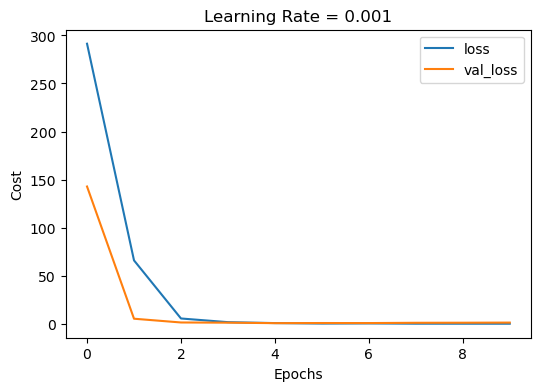

In [15]:
# plot the model
fig, ax = plt.subplots(figsize=(6, 4))
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.title("Learning Rate = 0.001")
plt.xlabel("Epochs")
plt.ylabel("Cost")
plt.legend()
plt.show()